In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('/workspaces/my_dissertation')
from visualizations.scripts.drawer import metric_viewer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import xarray as xr
from tqdm.notebook import tqdm
import glob
from visualizations.scripts.drawer import russia_plots, russia_plots_n
import seaborn as sns
import matplotlib.ticker as ticker
from copy import deepcopy

In [20]:
gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
ws_file = ws_file[ws_file['new_area'] <= 50000]
basemap_data = gpd.read_file(
    '../geo_data/great_db/geometry/russia_forest_25people.geojson')
ugms_shp = gpd.read_file(
    '../geo_data/great_db/geometry/ugms.shp')[['name1', 'geometry']]

### CDF for model runs

In [82]:
# random forest regressor
rfr_run, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# hbv
hbv_run, nse_hbv = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# gr4j
gr4j_run, nse_gr4j = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                  metric_col='NSE',
                                  gauges_file=gauges_file)
# tft (by gauge)
tft_run, nse_tft_single = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                        metric_col='NSE',
                                        gauges_file=gauges_file)
# tft (all together)
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)

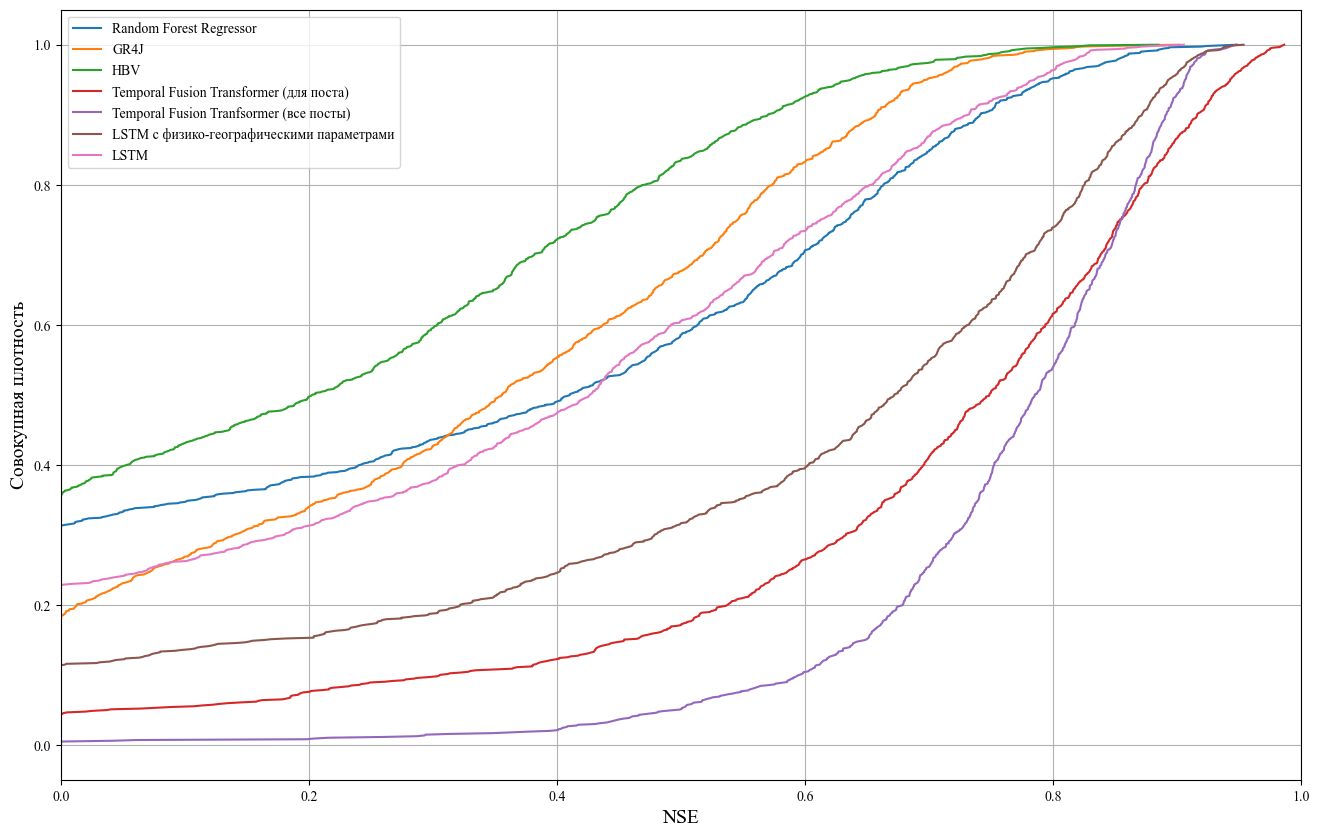

In [83]:
def ecdf(x: np.ndarray):
    """Calculate empirical cummulative density function
    
    Parameters
    ----------
    x : np.ndarray
        Array containing the data
    
    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys


fig, ax = plt.subplots(figsize=(16,10))

for name, fil in {'Random Forest Regressor': rfr_run['NSE'],
                  'GR4J': gr4j_run['NSE'],
                  'HBV': hbv_run['NSE'],
                  'Temporal Fusion Transformer (для поста)': tft_run['NSE'],
                  'Temporal Fusion Tranfsormer (все посты)': tft_256['NSE'],
                  'LSTM с физико-географическими параметрами': lstm_era5l['NSE'],
                  'LSTM': lstm_no_static['NSE']}.items():
    
    bin_, cdf_ = ecdf(fil.to_numpy())
    plt.plot(bin_, cdf_,
             label=f'{name}');
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('NSE', fontsize=14)
    ax.set_ylabel('Совокупная плотность', fontsize=14);

### Best meteo input

In [196]:
def get_r2(df,
           frequency: str,
           prcp_col: str,
           hydro_col: str = 'q_mm_day'):
    df = df.groupby(pd.Grouper(freq=frequency)).sum()
    df = pd.concat([df[prcp_col], df[hydro_col]], axis=1).dropna()
    return pearsonr(x=df[hydro_col], y=df[prcp_col])


res_df = list()
for file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
    
    gauge_id = file.split('/')[-1][:-3]
    test_df = xr.open_dataset(file)
    test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                      'prcp_e5', 'prcp_e5l',
                                      'prcp_gpcp', 'prcp_imerg',
                                      'prcp_mswep']]

    res_df.append(pd.DataFrame({prcp_col: get_r2(df=test_df,
                                frequency='30D',
                                prcp_col=prcp_col,
                                hydro_col='q_mm_day')[0]
    for prcp_col in ['prcp_e5', 'prcp_e5l',
                     'prcp_gpcp', 'prcp_imerg',
                     'prcp_mswep']},
                               index=[gauge_id]))
res_df = pd.concat(res_df)
res_df.index.name = 'gauge_id'
geom_r2 = gauges_file.set_index('gauge_id').join(res_df).dropna()

A Jupyter Widget

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient 

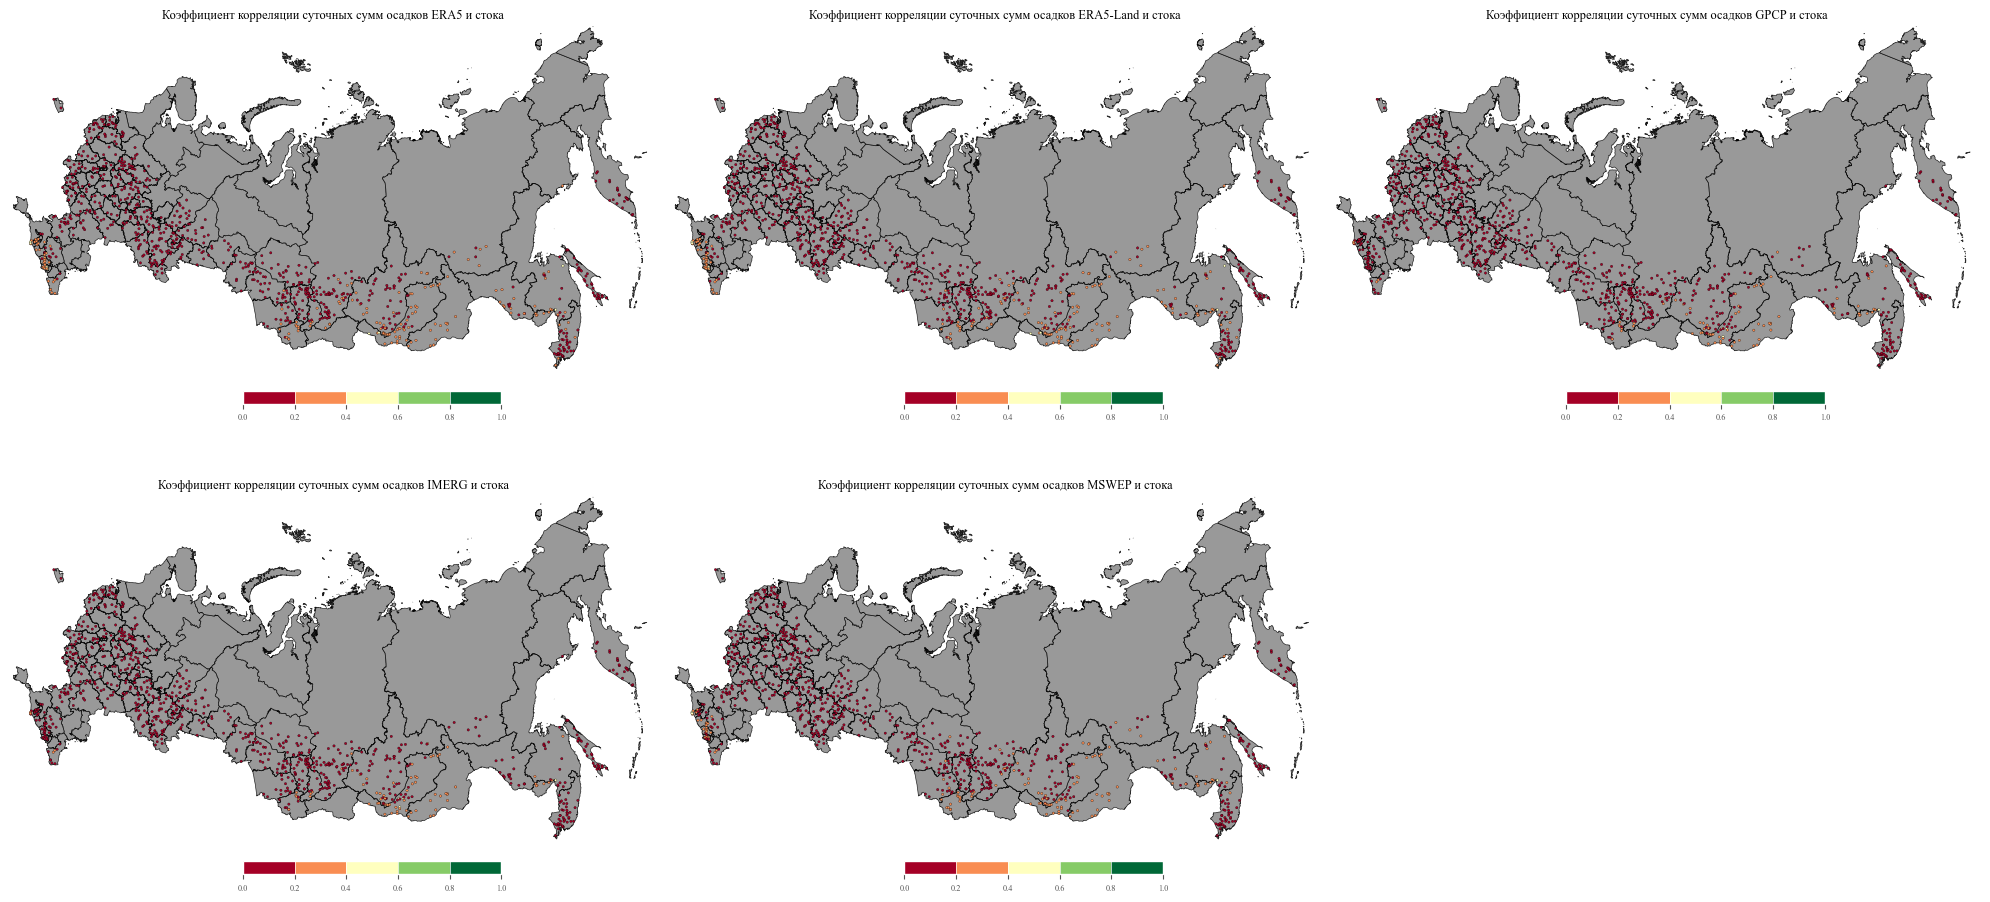

In [192]:
russia_plots_n(gdf_to_plot=geom_r2,
               basemap_data=basemap_data,
               cmap_name='RdYlGn',
               figsize=(20, 10),
               nrows=2,
               ncols=3,
               columns_from_gdf=['prcp_e5', 'prcp_e5l',
                                 'prcp_gpcp', 'prcp_imerg',
                                 'prcp_mswep'],
               with_histogram=False, title_text=['Коэффициент корреляции суточных сумм осадков ERA5 и стока',
                                                 'Коэффициент корреляции суточных сумм осадков ERA5-Land и стока',
                                                 'Коэффициент корреляции суточных сумм осадков GPCP и стока',
                                                 'Коэффициент корреляции суточных сумм осадков IMERG и стока',
                                                 'Коэффициент корреляции суточных сумм осадков MSWEP и стока']);

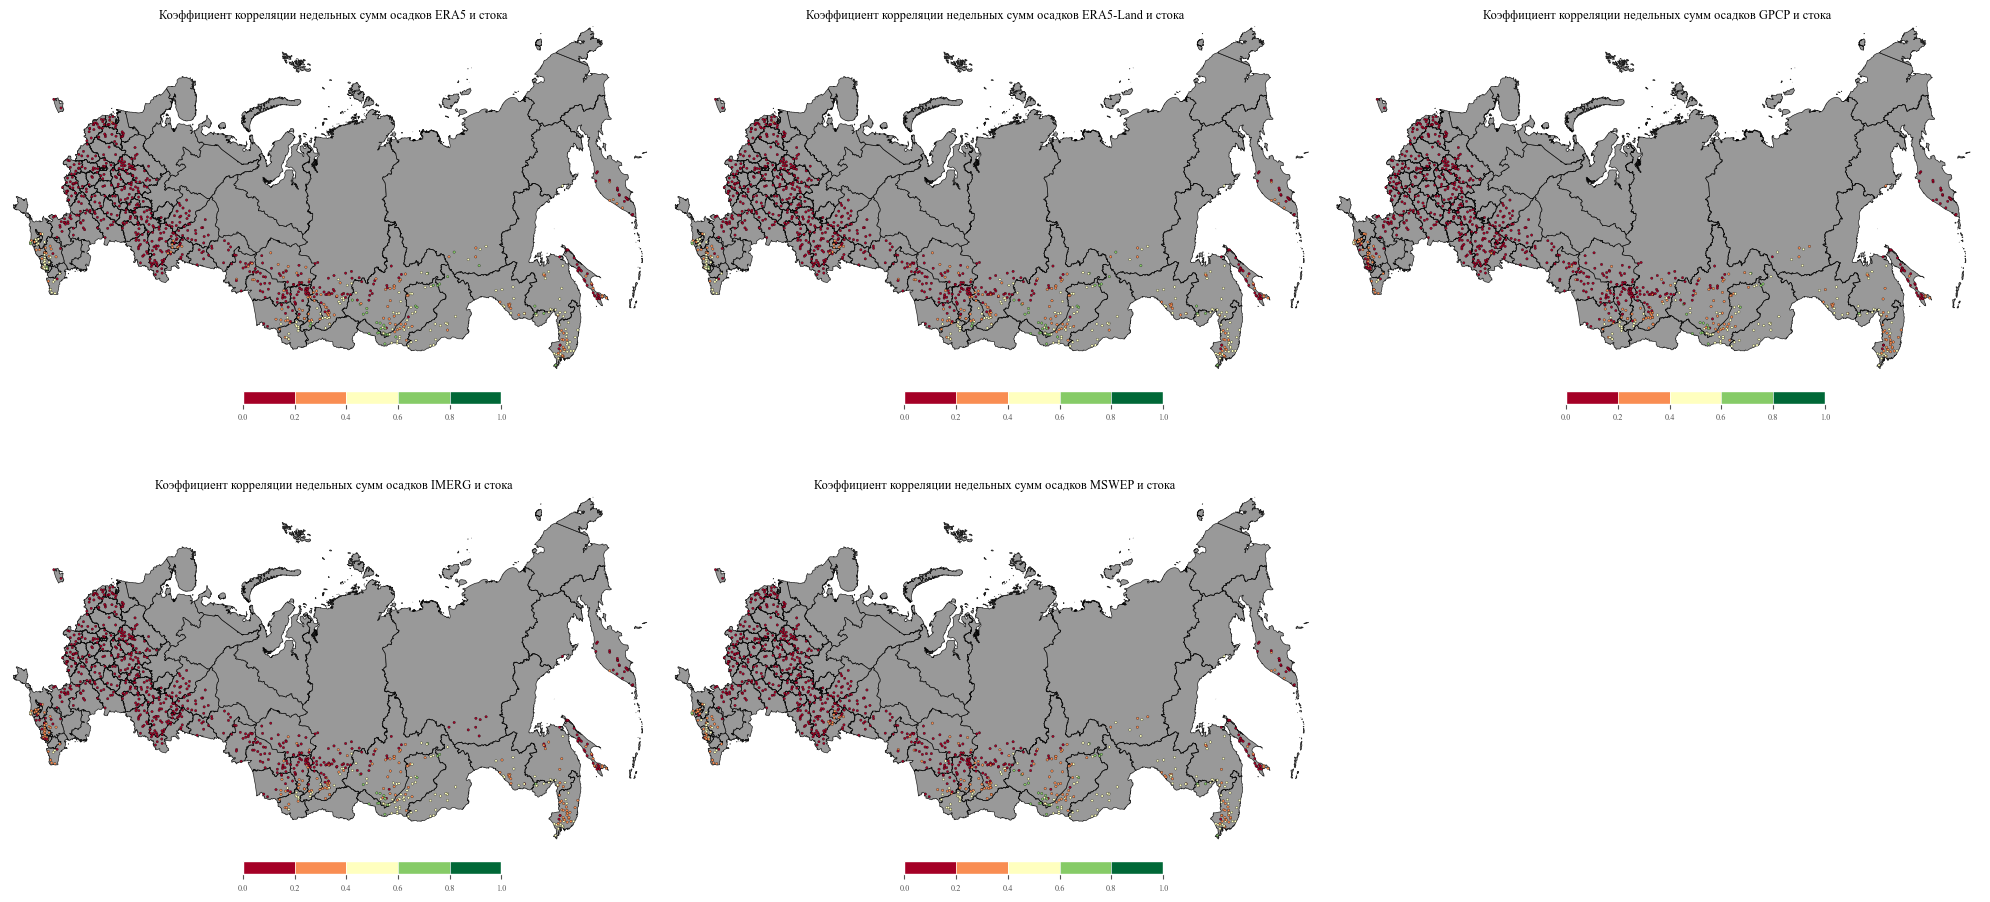

In [195]:
russia_plots_n(gdf_to_plot=geom_r2,
               basemap_data=basemap_data,
               cmap_name='RdYlGn',
               figsize=(20, 10),
               nrows=2,
               ncols=3,
               columns_from_gdf=['prcp_e5', 'prcp_e5l',
                                 'prcp_gpcp', 'prcp_imerg',
                                 'prcp_mswep'],
               with_histogram=False, title_text=['Коэффициент корреляции недельных сумм осадков ERA5 и стока',
                                                 'Коэффициент корреляции недельных сумм осадков ERA5-Land и стока',
                                                 'Коэффициент корреляции недельных сумм осадков GPCP и стока',
                                                 'Коэффициент корреляции недельных сумм осадков IMERG и стока',
                                                 'Коэффициент корреляции недельных сумм осадков MSWEP и стока']);

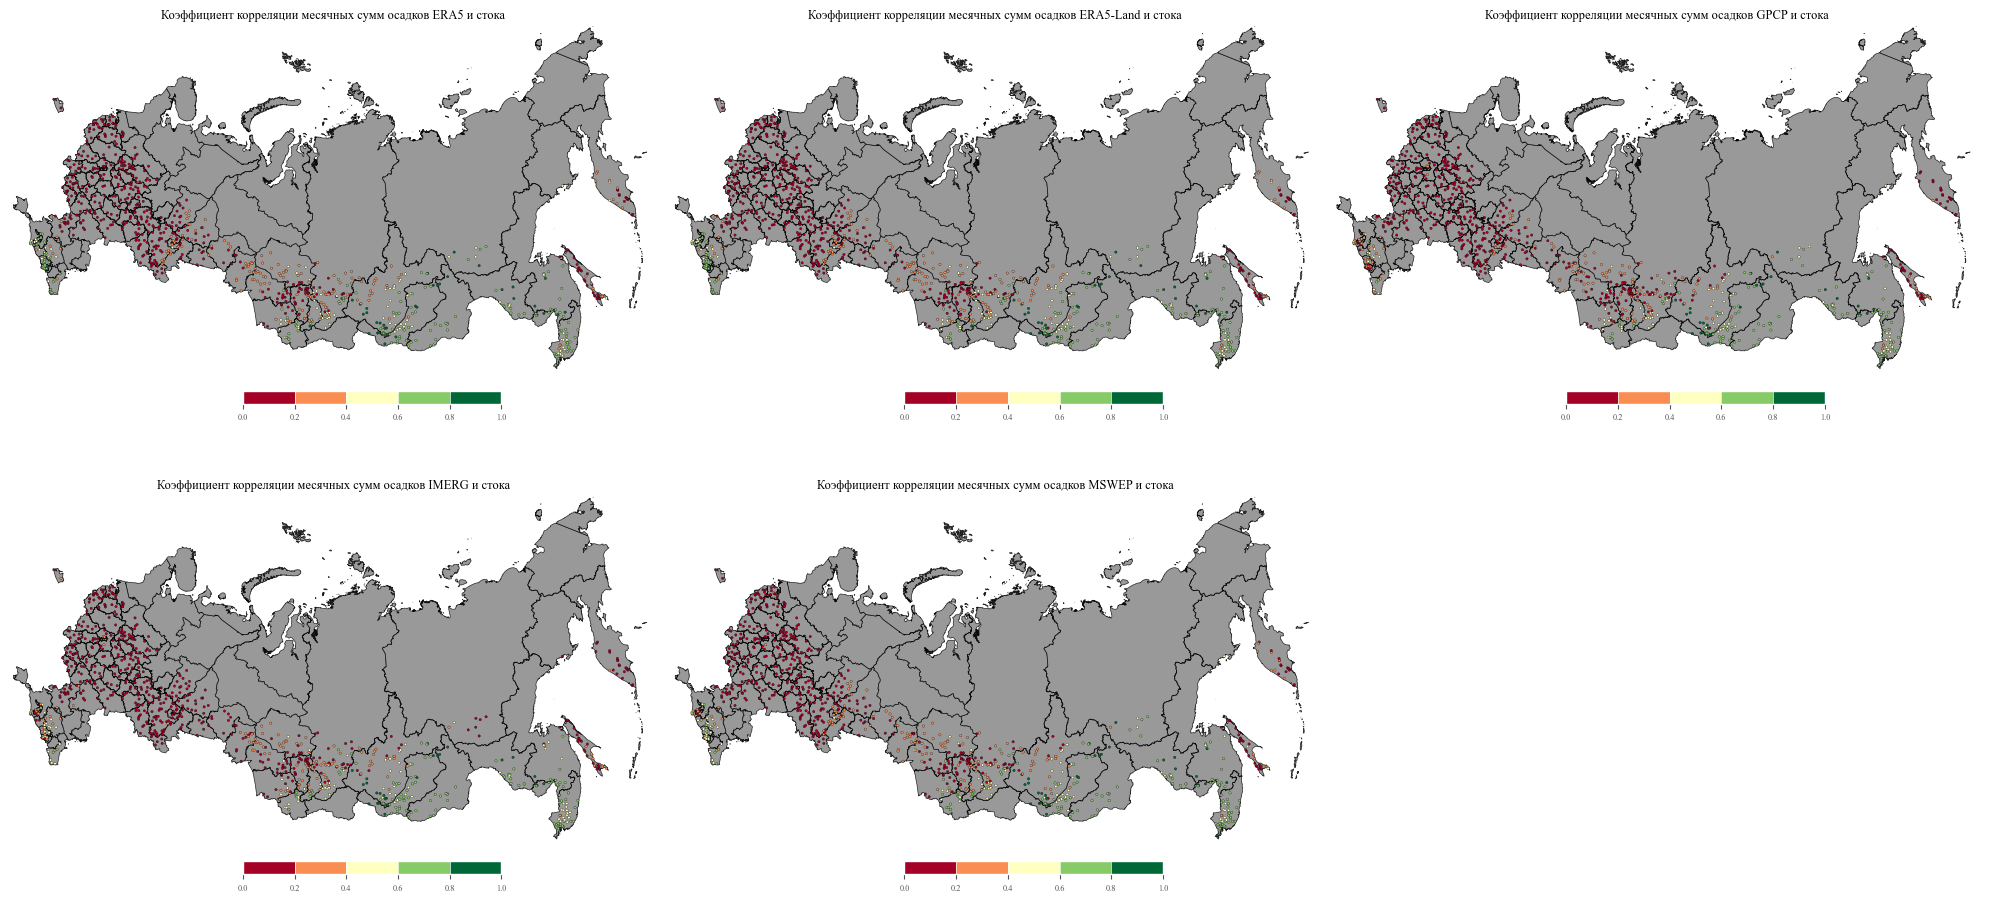

In [197]:
russia_plots_n(gdf_to_plot=geom_r2,
               basemap_data=basemap_data,
               cmap_name='RdYlGn',
               figsize=(20, 10),
               nrows=2,
               ncols=3,
               columns_from_gdf=['prcp_e5', 'prcp_e5l',
                                 'prcp_gpcp', 'prcp_imerg',
                                 'prcp_mswep'],
               with_histogram=False, title_text=['Коэффициент корреляции месячных сумм осадков ERA5 и стока',
                                                 'Коэффициент корреляции месячных сумм осадков ERA5-Land и стока',
                                                 'Коэффициент корреляции месячных сумм осадков GPCP и стока',
                                                 'Коэффициент корреляции месячных сумм осадков IMERG и стока',
                                                 'Коэффициент корреляции месячных сумм осадков MSWEP и стока']);

In [272]:
# lstm era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm era5
lstm_era5, nse_era5 = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5_SmallMedium_1205_112433/test/model_epoch021/test_metrics.csv',
                                    metric_col='NSE',
                                    gauges_file=gauges_file)
# lstm gpcp
lstm_gpcp, nse_gpcp = metric_viewer(metric_csv='../test_meteo_input/runs_static/gpcp_SmallMedium_1205_054740/test/model_epoch030/test_metrics.csv',
                                         metric_col='NSE',
                                         gauges_file=gauges_file)
# lstm imerg
lstm_imerg, nse_imerg = metric_viewer(metric_csv='../test_meteo_input/runs_static/imerg_SmallMedium_1205_085602/test/model_epoch030/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm mswep
lstm_mswep, nse_mswep = metric_viewer(metric_csv='../test_meteo_input/runs_static/mswep_static_SmallMedium_0205_153244/test/model_epoch021/test_metrics.csv',
                                          metric_col='NSE',
                                          gauges_file=gauges_file)
# lstm no static
lstm_no_static, nse_no_static = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                              metric_col='NSE',
                                              gauges_file=gauges_file)

In [303]:
nse_file = gpd.GeoDataFrame(geometry=lstm_era5['geometry'])
nse_file.index = lstm_era5.index
nse_file[['name_ru', 'name_en']] = lstm_era5[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5l['NSE']
nse_file['NSE_era5'] = lstm_era5['NSE']
nse_file['NSE_gpcp'] = lstm_gpcp['NSE']
nse_file['NSE_imerg'] = lstm_imerg['NSE']
nse_file['NSE_mswep'] = lstm_mswep['NSE']
nse_file['NSE_no_static'] = lstm_no_static['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
          'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = nse_file[
              ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
               'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].clip(lower=0)
nse_file

geometry                        name_ru   
gauge_id                                                              
49014      POINT (31.05794 65.77917)  р.Корпи-Йоки - пос.Пяозерский  \
49047      POINT (30.50502 64.95504)         р.Судно - с.Вокнаволок   
49052      POINT (31.14297 65.21779)          р.Ухта - пгт Калевала   
49058      POINT (32.11508 64.75309)      р.Чирко-Кемь - с.Юшкозеро   
49070      POINT (34.71204 64.74240)            р.Шуя - с.Шуерецкое   
...                              ...                            ...   
2027      POINT (157.97093 54.16468)              р.Берш - с.Пущино   
72191      POINT (33.87509 59.49075)       р.Дымка - г.Бокситогорск   
49053      POINT (31.22690 65.19361)    р.Норви-Йоки - пгт Калевала   
2107      POINT (158.36421 53.18661)        р.Половинка - г.Елизово   
7176      POINT (103.69834 51.64244)        р.Слюдянка - г.Слюдянка   

                                 name_en  NSE_era5l  NSE_era5  NSE_gpcp   
gauge_id                                                                  
49014     r.Korpi-Joki - pos.Pjaozerskij   0.544290  0.530573  0.000000  \
49047             r.Sudno - s.Voknavolok   0.683292  0.690868  0.565371   
49052              r.Uhta - pgt Kalevala   0.846952  0.788134  0.000000   
49058       r.Chirko-Kem' - s.Jushkozero   0.816702  0.537572  0.000000   
49070            r.Shuja - s.Shueretskoe   0.477104  0.695161  0.424141   
...                                  ...        ...       ...       ...   
2027                r.Bersh - s.Puschino   0.478540  0.578561  0.462588   
72191           r.Dymka - g.Boksitogorsk   0.000000  0.000000  0.000000   
49053        r.Norvi-Joki - pgt Kalevala   0.661735  0.092495  0.000000   
2107             r.Polovinka - g.Elizovo   0.785542  0.863505  0.737244   
7176         r.Sljudjanka - g.Sljudjanka   0.296994  0.310421  0.551323   

          NSE_imerg  NSE_mswep  NSE_no_static  
gauge_id                                       
49014           NaN   0.514372       0.638239  
49047           NaN   0.635370       0.234485  
49052           NaN   0.813186       0.548791  
49058           NaN   0.821513       0.000000  
49070           NaN   0.562544       0.256056  
...             ...        ...            ...  
2027       0.524595   0.500532       0.692436  
72191      0.000000   0.000000       0.000000  
49053           NaN   0.448048       0.181011  
2107       0.734392   0.826731       0.795215  
7176       0.379954   0.417083       0.209563  

[911 rows x 9 columns]

In [304]:
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = ugms_part[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                                                              'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].median()

A Jupyter Widget

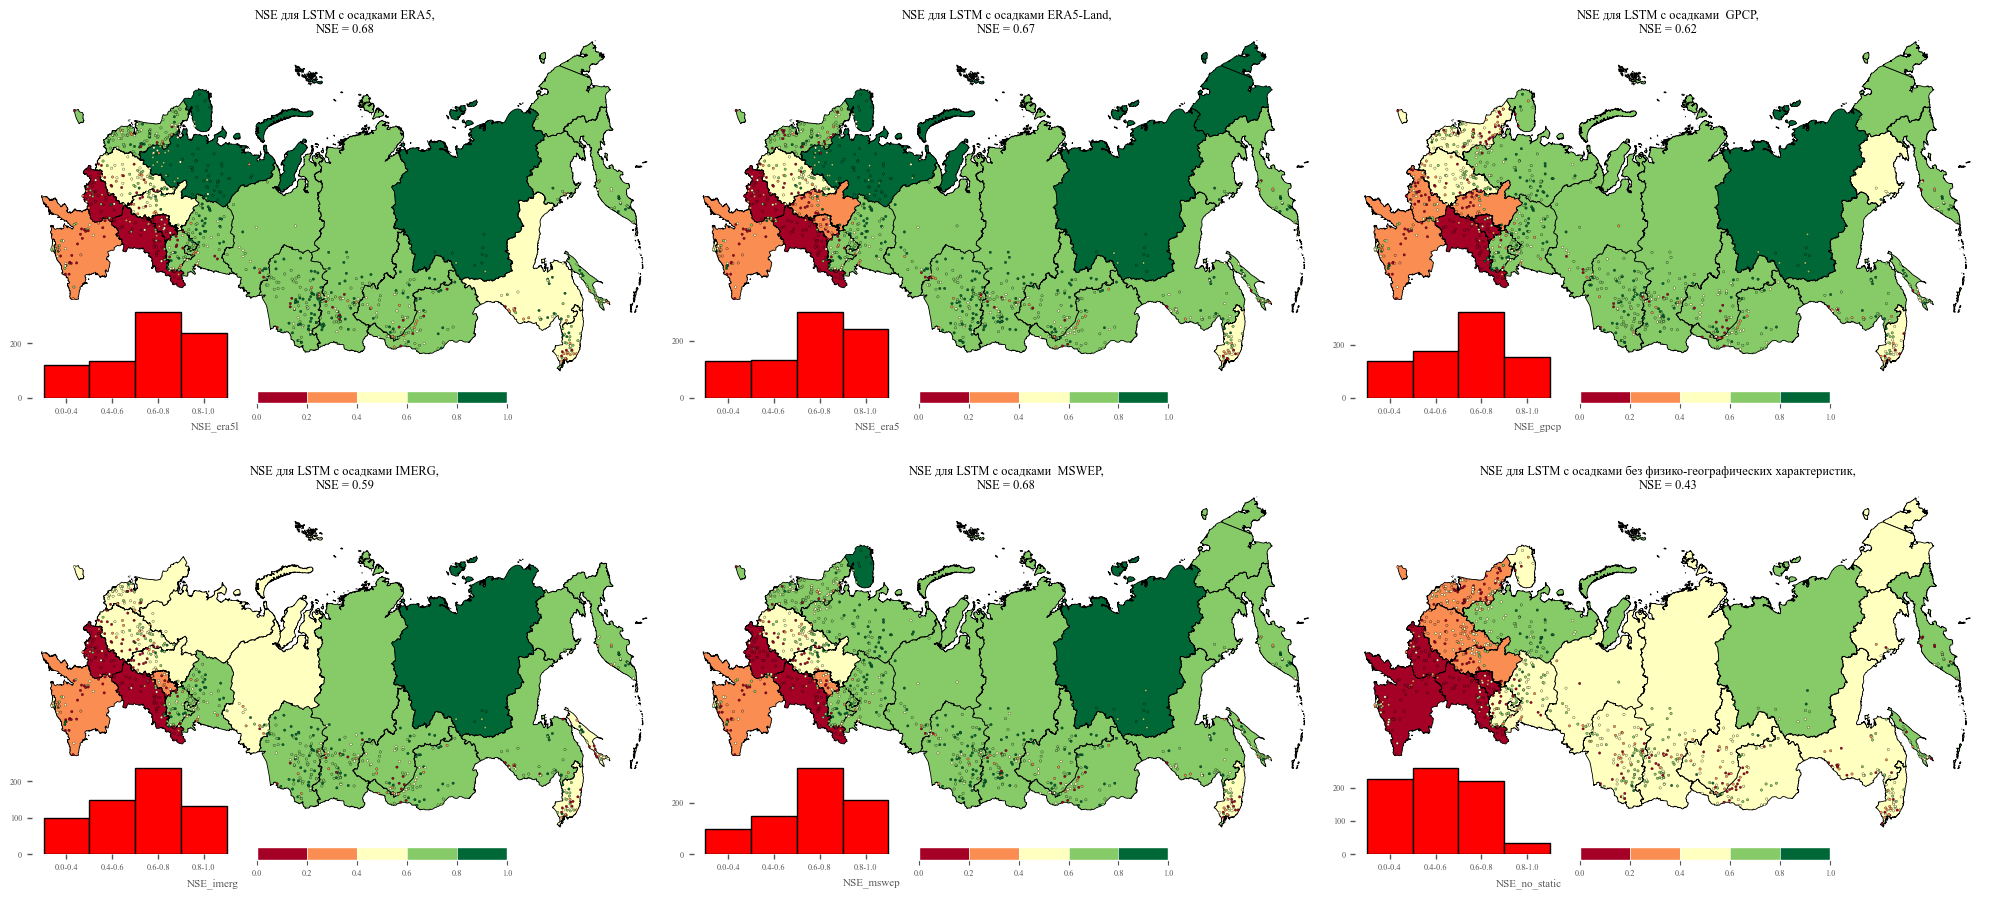

In [306]:
russia_plots_n(gdf_to_plot=nse_file,
               basemap_data=basemap_data,
               cmap_name='RdYlGn',
               figsize=(20, 10),
               nrows=2,
               ncols=3,
               columns_from_gdf=['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                 'NSE_imerg', 'NSE_mswep', 'NSE_no_static'],
               with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5,\nNSE = {nse_era5:.2f}',
                                                 f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                 f'NSE для LSTM с осадками  GPCP,\nNSE = {nse_gpcp:.2f}',
                                                 f'NSE для LSTM с осадками IMERG,\nNSE = {nse_imerg:.2f}',
                                                 f'NSE для LSTM с осадками  MSWEP,\nNSE = {nse_mswep:.2f}',
                                                 f'NSE для LSTM с осадками без физико-географических характеристик,\nNSE = {nse_no_static:.2f}'],
               ugms=True, ugms_gdf=ugms_shp);

### Spatial distribution of NSE quality

In [13]:
# tft era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# tft single era5l
tft_era5l, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# tft single era5l
tft_all_era5l, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# hbv era5l
hbv_era5l, nse_hbv = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j era5l
gr4j_era5l, nse_gr4j = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# rfr era5l
rfr_era5l, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
nse_file = gpd.GeoDataFrame(geometry=lstm_era5l['geometry'])
nse_file.index = lstm_era5l.index
nse_file[['name_ru', 'name_en']] = lstm_era5l[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5l['NSE']
nse_file['NSE_TFT'] = tft_era5l['NSE']
nse_file['NSE_TFT_all'] = tft_all_era5l['NSE']
nse_file['NSE_hbv'] = hbv_era5l['NSE']
nse_file['NSE_gr4j'] = gr4j_era5l['NSE']
nse_file['NSE_rfr'] = rfr_era5l['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
          'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = nse_file[
              ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
               'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].clip(lower=0)

for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = ugms_part[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                                                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].median()

A Jupyter Widget

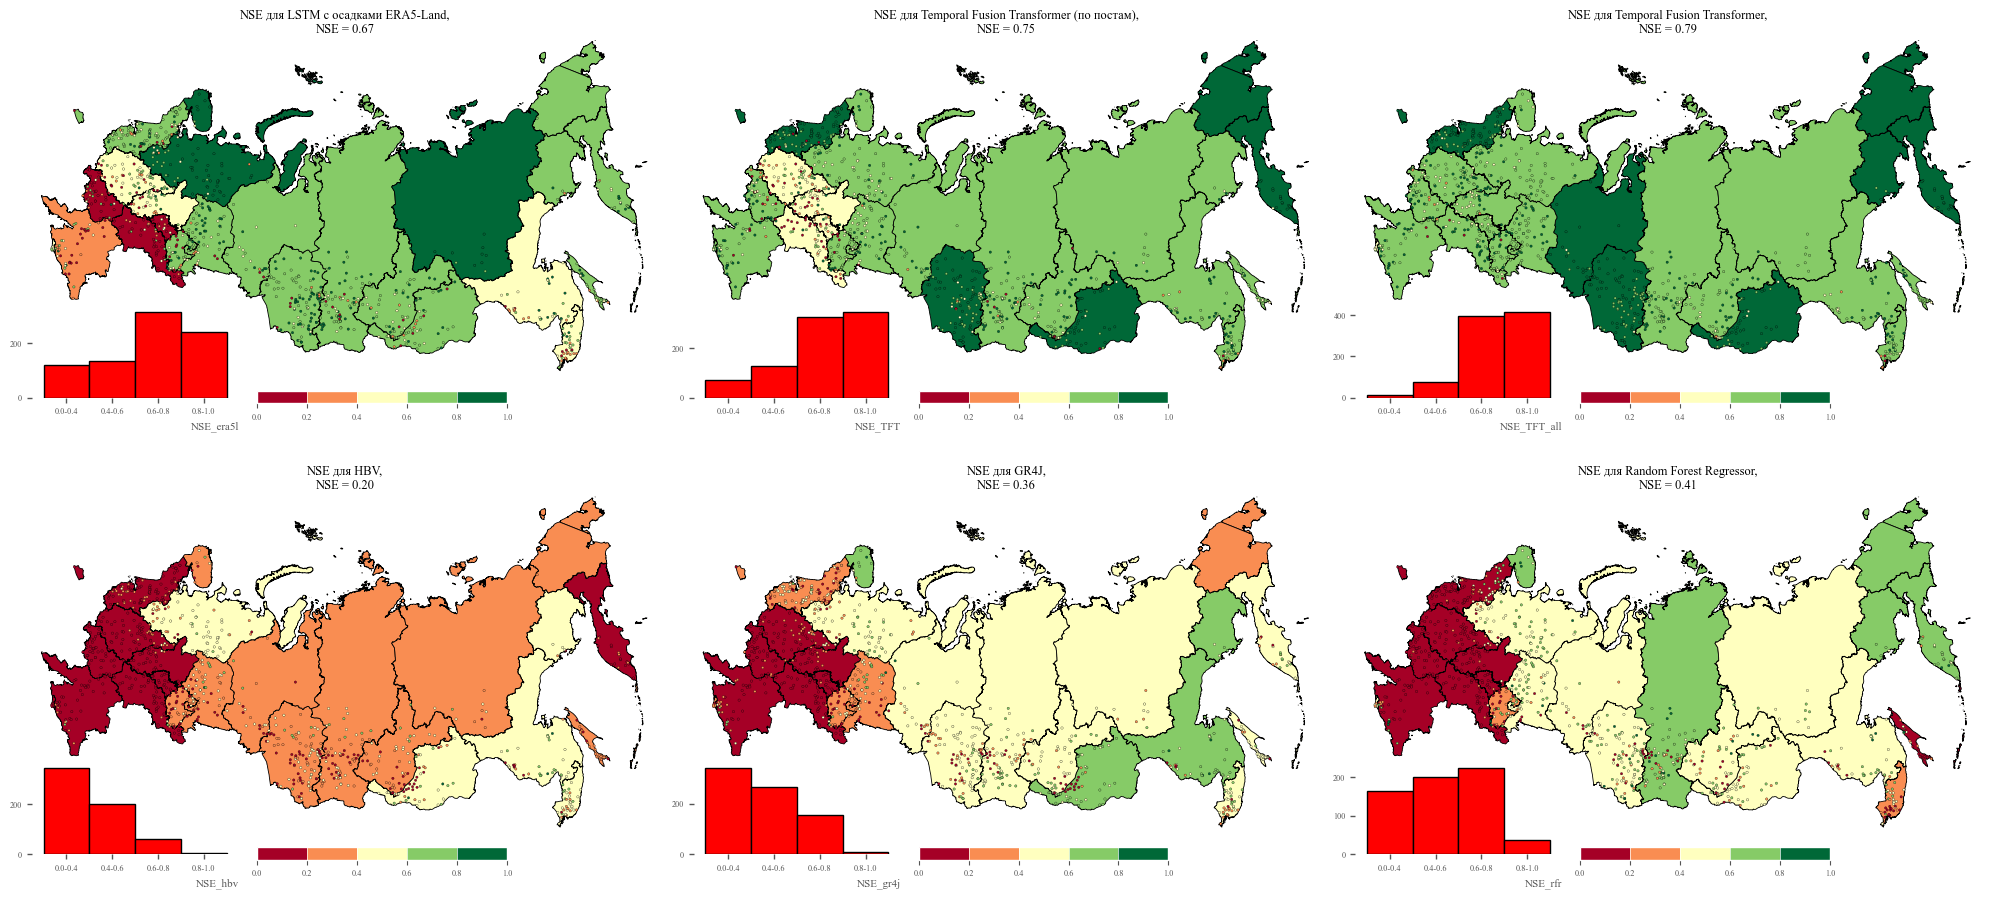

In [314]:
russia_plots_n(gdf_to_plot=nse_file,
               basemap_data=basemap_data,
               cmap_name='RdYlGn',
               figsize=(20, 10),
               nrows=2,
               ncols=3,
               columns_from_gdf=['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                 'NSE_hbv', 'NSE_gr4j', 'NSE_rfr'],
               with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                f'NSE для Temporal Fusion Transformer (по постам),\nNSE = {nse_tft:.2f}',
                                                f'NSE для Temporal Fusion Transformer,\nNSE = {nse_tft_all:.2f}',
                                                f'NSE для HBV,\nNSE = {nse_hbv:.2f}',
                                                f'NSE для GR4J,\nNSE = {nse_gr4j:.2f}',
                                                f'NSE для Random Forest Regressor,\nNSE = {nse_rfr:.2f}'],
               ugms=True, ugms_gdf=ugms_shp);

### TFT attributs (feature importance, attention, etc.)

In [321]:
tft_era5l

name_ru                            name_en   
gauge_id                                                                        
49014        р.Корпи-Йоки - пос.Пяозерский     r.Korpi-Joki - pos.Pjaozerskij  \
49047               р.Судно - с.Вокнаволок             r.Sudno - s.Voknavolok   
49052                р.Ухта - пгт Калевала              r.Uhta - pgt Kalevala   
49058            р.Чирко-Кемь - с.Юшкозеро       r.Chirko-Kem' - s.Jushkozero   
49070                  р.Шуя - с.Шуерецкое            r.Shuja - s.Shueretskoe   
...                                    ...                                ...   
5664       р.Левый Ул - пос.Многовершинный   r.Levyj Ul - pos.Mnogovershinnyj   
49053          р.Норви-Йоки - пгт Калевала        r.Norvi-Joki - pgt Kalevala   
2107               р.Половинка - г.Елизово            r.Polovinka - g.Elizovo   
2106      р.Половинка - в 13.7 км от устья  r.Polovinka - v 13.7 km ot ust'ja   
7176               р.Слюдянка - г.Слюдянка        r.Sljudjanka - g.Sljudjanka   

                            geometry       NSE    day      static    encoder   
gauge_id                                                                       
49014      POINT (31.05794 65.77917)  0.949277  294.0  inu_pc_ult   prcp_e5l  \
49047      POINT (30.50502 64.95504)  0.951980    1.0  ele_mt_sav   q_mm_day   
49052      POINT (31.14297 65.21779)  0.732684    1.0  ire_pc_sse   prcp_e5l   
49058      POINT (32.11508 64.75309)  0.975160   74.0  ele_mt_sav   q_mm_day   
49070      POINT (34.71204 64.74240)  0.744663   24.0  lkv_mc_usu   q_mm_day   
...                              ...       ...    ...         ...        ...   
5664      POINT (139.86442 53.61337)  0.843053   62.0  sgr_dk_sav   prcp_e5l   
49053      POINT (31.22690 65.19361)  0.953800  365.0  lkv_mc_usu  t_max_e5l   
2107      POINT (158.36421 53.18661)  0.927761    1.0  lka_pc_use   q_mm_day   
2106      POINT (158.21890 53.16076)  0.838575  202.0  sgr_dk_sav   q_mm_day   
7176      POINT (103.69834 51.64244)  0.193418    1.0  ire_pc_sse   q_mm_day   

            decoder  
gauge_id             
49014      prcp_e5l  
49047      prcp_e5l  
49052     t_max_e5l  
49058     t_max_e5l  
49070     t_max_e5l  
...             ...  
5664       prcp_e5l  
49053     t_max_e5l  
2107      t_min_e5l  
2106      t_min_e5l  
7176       prcp_e5l  

[909 rows x 8 columns]

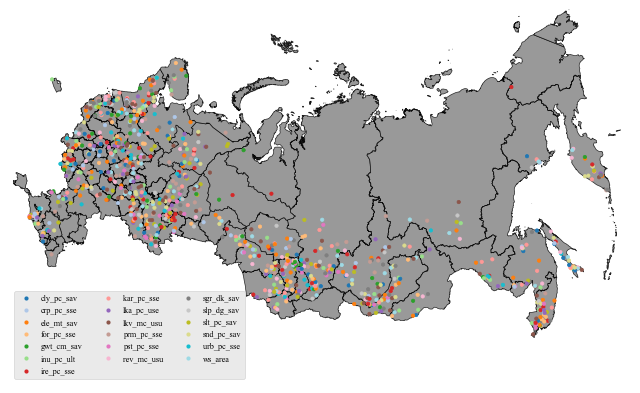

In [346]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='static',
                          cmap_name='tab20',
                          figsize=(8, 6),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('../visualizations/into_dissertation/static_TFT.png',
                   dpi=650)

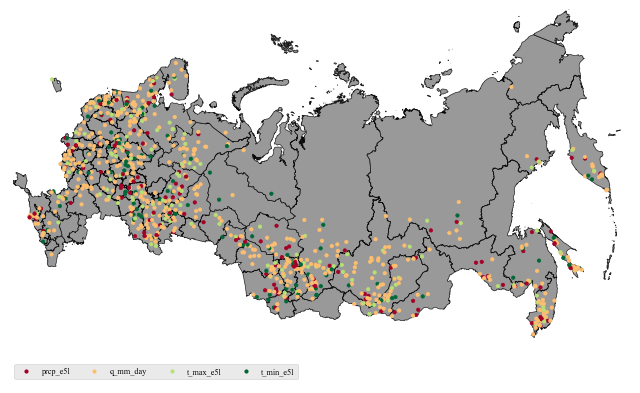

In [351]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='encoder',
                          figsize=(8, 6),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('../visualizations/into_dissertation/encoder_TFT.png',
                   dpi=650)

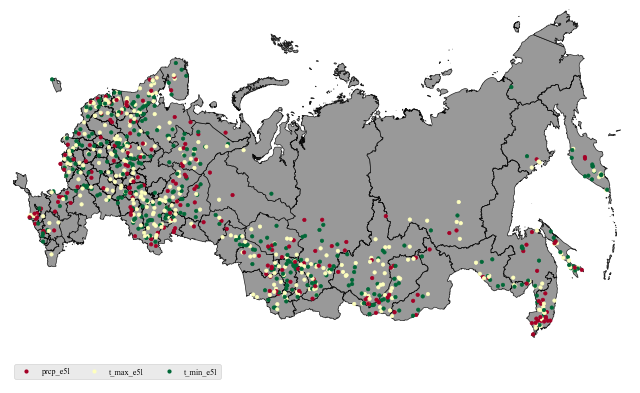

In [352]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='decoder',
                          figsize=(8, 6),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('../visualizations/into_dissertation/decoder_TFT.png',
                   dpi=650)

In [358]:
def day_to_attnt(val: float):
    if val < 7:
        return 'Быстряя'
    elif (val >= 7) & (val <= 30):
        return 'Средняя'
    elif (val >= 30) & (val <= 90):
        return 'Средне-длинная'
    else:
        return 'Длинная'
tft_era5l['attention'] = tft_era5l['day'].apply(lambda x: day_to_attnt(x))

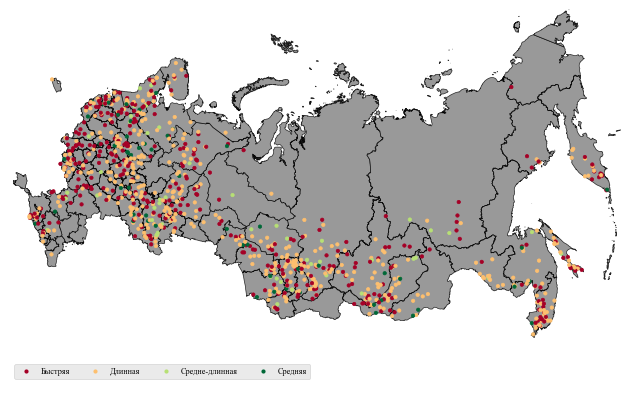

In [359]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='attention',
                          figsize=(8, 6),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('../visualizations/into_dissertation/attention_TFT.png',
                   dpi=650)

### GMC forecast quality

In [365]:
def find_gmc(predictions: np.ndarray, observations: np.ndarray,
             days_shift: int, eq_param: int, with_p=False) -> np.ndarray:
    """[summary]

    Args:
        predictions (np.array): [description]
        observations (np.array): [description]
        days_shift (int): [description]

    Returns:
        np.array: [description]
    """

    predictions_error = np.array(observations - predictions)
    delta_1 = np.array(observations[:-days_shift]-observations[days_shift:])
    sigma = np.std(delta_1-np.mean(delta_1), ddof=1)
    gmc_criteria = np.abs(0.674*sigma)
    S = np.sqrt(np.sum([i**2 for i in predictions_error]) /
                (len(predictions_error)-eq_param))

    S_sigma = S/sigma

    descision = ['Прогноз оправдывается' if np.abs(error) <= gmc_criteria
                 else 'Прогноз не оправдывается'
                 for error in predictions_error]

    values, counts = np.unique(descision, return_counts=True)
    try:
        first_value, second_value = counts
        first_key, second_key = values
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{first_key} -- {first_value} раз(а),
    {second_key} -- {second_value} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = second_value/(first_value + second_value)
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {S_sigma:.2f} -- длина ряда {len(predictions_error)}')
    except:
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{values[0]} -- {counts[0]} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = 0
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {S_sigma:.2f} -- длина ряда {len(predictions_error)}')
    if with_p:
        return np.array([np.round(S*100, decimals=1),
                         np.round(sigma*100, decimals=1),
                         np.round(S_sigma, decimals=2),
                         f'{accuracy:.1%}'])

    else:
        return np.array([np.round(gmc_criteria, decimals=3),
                         np.round(accuracy*100, decimals=2)])

In [373]:
for gauge_id in tft_era5l.index:
    test_df = pd.read_csv(f'./results/tft_single/{gauge_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    tft_era5l.loc[gauge_id, 'ГМЦ'] = find_gmc(
        predictions=test_df['q_mm_day_pred'].to_numpy(),
        observations=test_df['q_mm_day'].to_numpy(),
        days_shift=7, eq_param=24, with_p=False)[1]


Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 37 раз(а),
    Прогноз оправдывается -- 688 раз(а)
Критерий точности ГМЦ +/- 0.334
Оправдываемость прогнозов по методике ГМЦ 94.90%
S/sigma_delta 0.43 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 122 раз(а),
    Прогноз оправдывается -- 603 раз(а)
Критерий точности ГМЦ +/- 0.552
Оправдываемость прогнозов по методике ГМЦ 83.17%
S/sigma_delta 0.52 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 112 раз(а),
    Прогноз оправдывается -- 613 раз(а)
Критерий точности ГМЦ +/- 0.422
Оправдываемость прогнозов по методике ГМЦ 84.55%
S/sigma_delta 0.75 -- длина ряда 725

Качество прогноза заблаговременностью 7 день
Результаты оценки качества прогноза:
Прогноз не оправдывается -- 60 раз(а),
    Прогноз оправдывается -- 665 раз

In [381]:
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = tft_era5l.loc[[geom.intersects(gage_point)
                              for gage_point in tft_era5l['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['ГМЦ']] = ugms_part[['ГМЦ']].median()

A Jupyter Widget

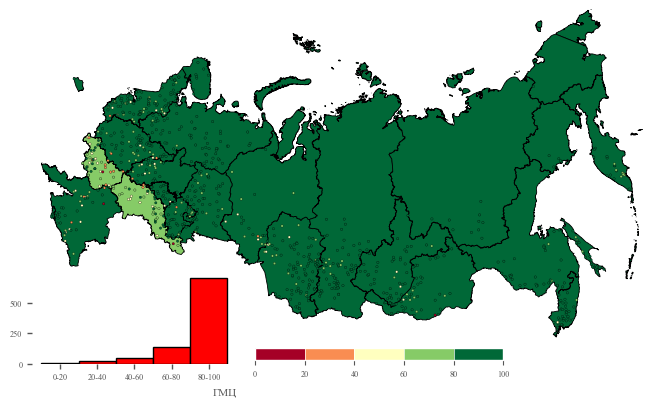

In [391]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='',
                          list_of_limits=[0, 20, 40, 60, 80, 100],
                          figsize=(8, 6),
                          title_text='',
                          with_histogram=True,
                          ugms=True, ugms_gdf=ugms_shp,
                          just_points=False, metric_col='ГМЦ')
gauges_fig.savefig('../visualizations/into_dissertation/GMC_tft.png',
                   dpi=650)

In [366]:
test_df = pd.read_csv('./results/tft_single/10044.csv',
                      index_col='date')
test_df.index = pd.to_datetime(test_df.index)
test_df

q_mm_day  q_mm_day_pred
date                               
2019-01-01  0.229353       0.256738
2019-01-02  0.223678       0.231382
2019-01-03  0.218002       0.239144
2019-01-04  0.212327       0.235815
2019-01-05  0.206652       0.251356
...              ...            ...
2020-12-21  0.360555       0.348478
2020-12-22  0.353878       0.347604
2020-12-23  0.347201       0.372509
2020-12-24  0.340524       0.432434
2020-12-25  0.331511       0.468575

[725 rows x 2 columns]

In [408]:
def lim_definer(area: float):

    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return '< 100 $км^2$'
    elif (area >= lim_1) & (area <= lim_2):
        return '100 $км^2$ - 2 000 $км^2$'
    elif (area > lim_2) & (area <= lim_3):
        return '2 000 $км^2$ - 10 000 $км^2$'
    elif (area > lim_3) & (area <= lim_4):
        return '10 000 $км^2$ - 50 000 $км^2$'
    else:
        return '> 50 000 $км^2$'

ws_file['size'] = ws_file.loc[:, 'new_area'].apply(lambda x: lim_definer(x))
ws_file['size'] = pd.Categorical(ws_file['size'],
                                 ['< 100 $км^2$',
                                  '100 $км^2$ - 2 000 $км^2$',
                                  '2 000 $км^2$ - 10 000 $км^2$',
                                  '10 000 $км^2$ - 50 000 $км^2$'])
ws_file = ws_file.loc[tft_era5l.index, :]

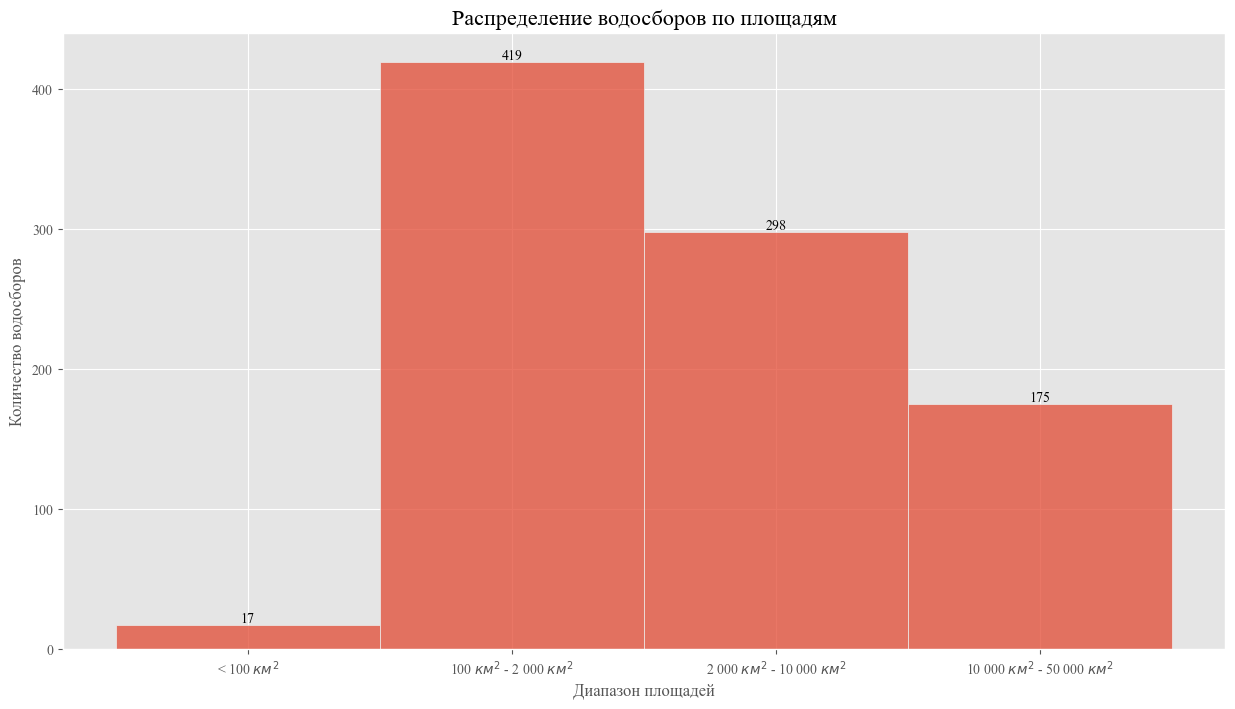

In [467]:

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws_file,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 500, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 500, 100));
area_hist.set_xlabel('Диапазон площадей')
area_hist.set_ylabel('Количество водосборов')
area_hist.bar_label(area_hist.containers[1], fmt='%.0f')

area_hist.set_title(f"""Распределение водосборов по площадям""", fontsize=16);
plt.savefig('../visualizations/into_dissertation/area_distribution.png',
                   dpi=650)

In [433]:
ws_file['NSE'] = tft_era5l['NSE']
ws_file['ГМЦ'] = tft_era5l['ГМЦ']

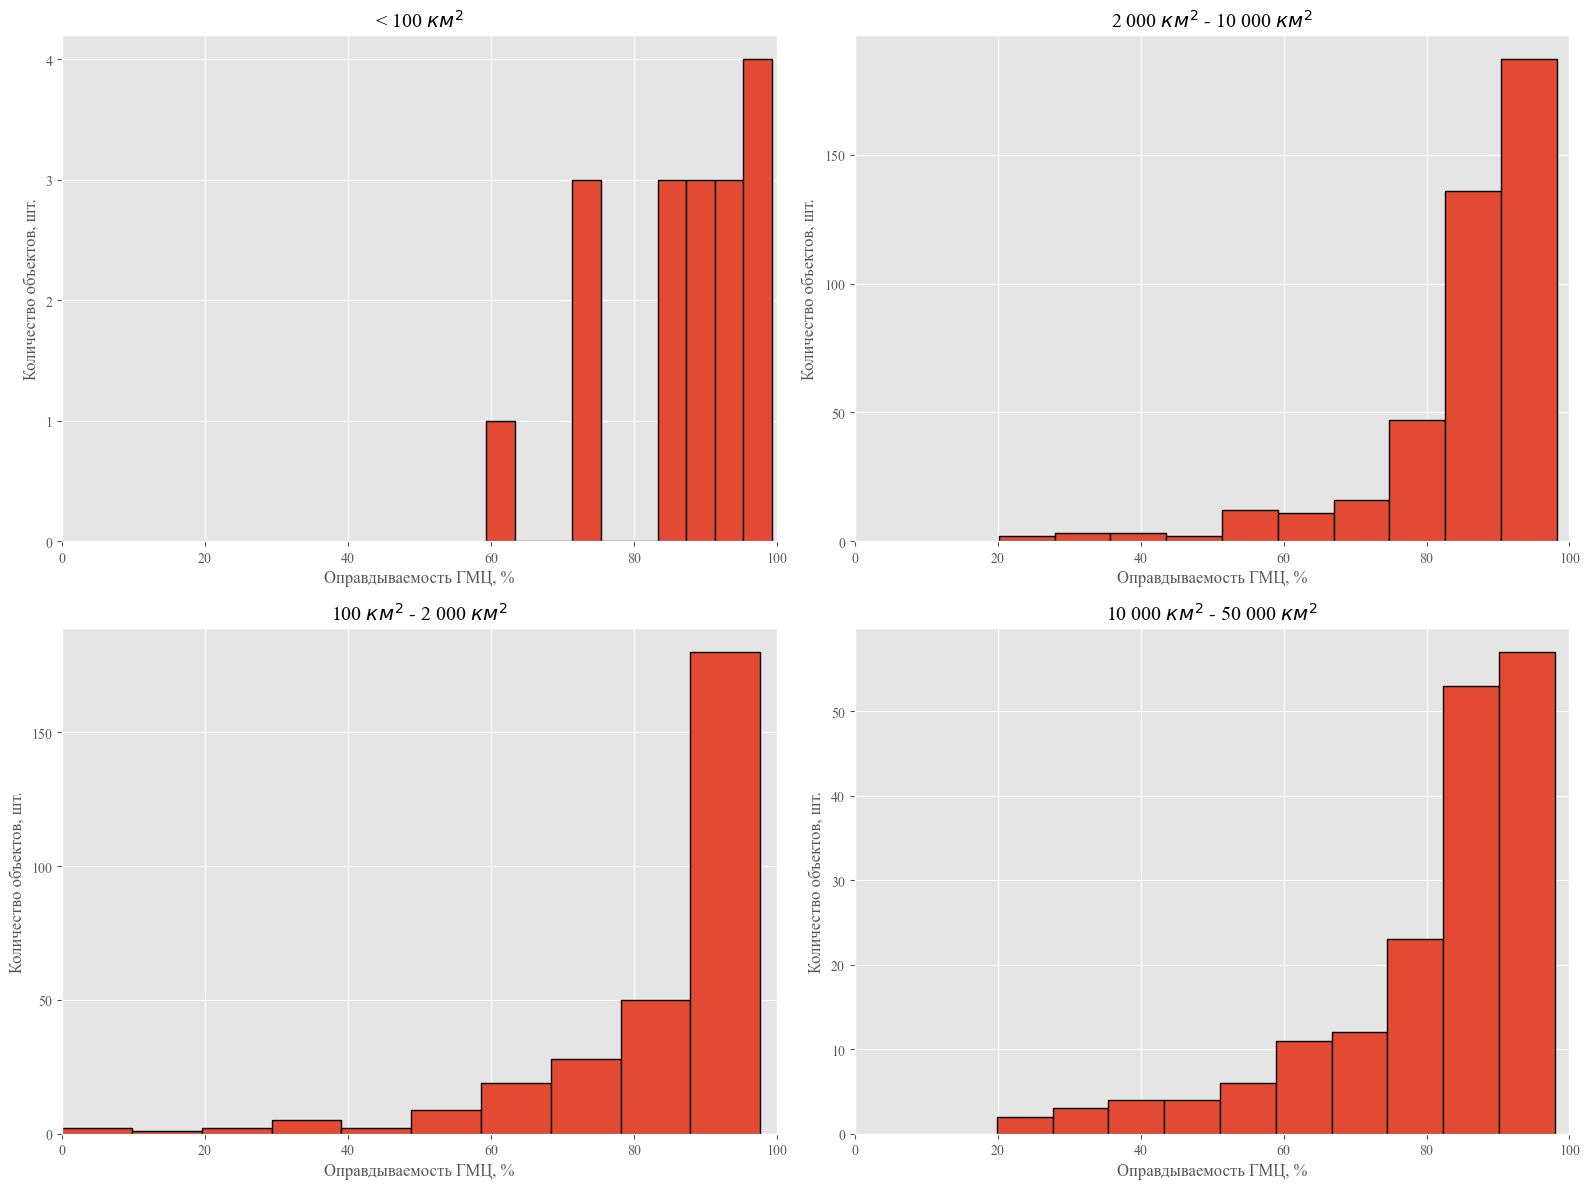

In [460]:

my_hist = ws_file.hist(column='ГМЦ',
                       by='size',
                       figsize=(16, 12),
                       edgecolor='black', linewidth=1)

xlbl = [str(col).replace(', ', '-')
        for col in np.unique(ws_file['size'])]
# xlbl = [f'{lbl}, sq. km' for lbl in xlbl]

for i, ax in enumerate(my_hist.flatten()[::-1]):
    ax.set_title(xlbl[i])
    ax.set_xlabel("Оправдываемость ГМЦ, %")
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.set_ylabel('Количество объектов, шт.')
    ax.locator_params(axis='y', nbins=7)
    ax.set_xlim((0, 100))
    ax.locator_params(axis='x', nbins=5)
    ax.tick_params(axis='x', labelrotation=0);
plt.tight_layout()
plt.savefig('../visualizations/into_dissertation/gmc_distribution.png',
            dpi=650)


In [525]:
def nse_descriptor(nse_df: pd.DataFrame,
                   model_name: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Модель'] = model_name
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(nse_df):.0f}'
    
    nse_max = nse_df['NSE'].max()
    res_df.loc[0, 'Максимум NSE'] = f'{nse_max:.2f}'
    
    nse_median = nse_df['NSE'].median()
    res_df.loc[0, 'Медианный NSE'] = f'{nse_median:.2f}'
    
    nse_mean = nse_df['NSE'].mean()
    res_df.loc[0, 'Средний NSE'] = f'{nse_mean:.2f}'
    
    nse_min = nse_df['NSE'].min()
    res_df.loc[0, 'Минимум NSE'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (nse_df['NSE'] < 0).sum()
    res_df.loc[0, 'NSE < 0'] = f'{nse_less_t_z:.0f}'
    
    
    return res_df

In [527]:
from copy import deepcopy
test_gr4j = deepcopy(gr4j_era5l)
test_rfr = deepcopy(rfr_era5l)

for g_id in test_gr4j.index:
    if g_id in ws_file.index:
        pass
    else:
        test_gr4j = test_gr4j.drop(g_id)

for g_id in test_rfr.index:
    if g_id in ws_file.index:
        pass
    else:
        test_rfr = test_rfr.drop(g_id)
res_list = list()
for model, res in {
    'LSTM физ. гео ERA5-Land': lstm_era5l,
    'LSTM физ. гео ERA5': lstm_era5,
    'LSTM физ. гео GPCP': lstm_gpcp,
    'LSTM физ. гео IMERG': lstm_imerg,
    'LSTM физ. гео MSWEP': lstm_mswep,
    'LSTM ERA5-Land без физ. гео': lstm_no_static.loc[ws_file.index, :],
    'Temporal Fusion Transformer (для поста)': tft_era5l,
    'Temporal Fusion Transformer (все посты)': tft_all_era5l,
    'HBV ERA5-Land': hbv_era5l.loc[ws_file.index, :],
    'GR4J ERA5-Land': test_gr4j,
        'RandomForestRegressor ERA5-Land': test_rfr}.items():
    res_list.append(nse_descriptor(nse_df=res, model_name=model))
pd.concat(res_list).sort_values(by='Медианный NSE',
                                ascending=False).reset_index(drop=True).to_csv('./results/model_quality.csv', index=False)

### q5, q95, mean, baseflow 

In [528]:
from scripts.hydro_metrics import hydro_job
from scripts.processing import split_by_hydro_year, split_by_year

In [532]:
test_df = pd.read_csv('./results/tft_256/10042.csv',
                      index_col='date')
test_df.index = pd.to_datetime(test_df.index)

In [561]:
test_df.columns

Index(['q_mm_day', 'q_mm_day_pred'], dtype='object')

In [581]:
gage_comp = dict()
final_list = list()
for g_id in tqdm(ws_file.index):
    gage_comp[g_id] = dict()
    test_df = pd.read_csv(f'./results/tft_256/{g_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    for col in test_df.columns:
        year_res = list()
        hydro_years = split_by_hydro_year(test_df[col])
        calendar_years = split_by_year(test_df[col])

        for year in hydro_years.keys():
            year_res.append(pd.DataFrame(hydro_job(hydro_year=hydro_years[year],
                                                   calendar_year=calendar_years[year]),
                                         index=[0]))
        year_res = pd.concat(year_res)
        gage_comp[g_id][col] = year_res
    res_df = (gage_comp[g_id]['q_mm_day'] - gage_comp[g_id]
              ['q_mm_day_pred'])/gage_comp[g_id]['q_mm_day'] * 100
    res_df = res_df.mean().to_frame().T
    res_df['gauge_id'] = g_id
    final_list.append(res_df)
tft_stats = pd.concat(final_list).set_index('gauge_id', drop=True)

A Jupyter Widget

In [588]:
tft_era5l[['mean', 'bfi', 'q5', 'q95']] = tft_stats

In [618]:
tft_stats.mean()

mean   -14.390340
bfi     -5.275942
q5     -11.874552
q95     39.252894
dtype: float64

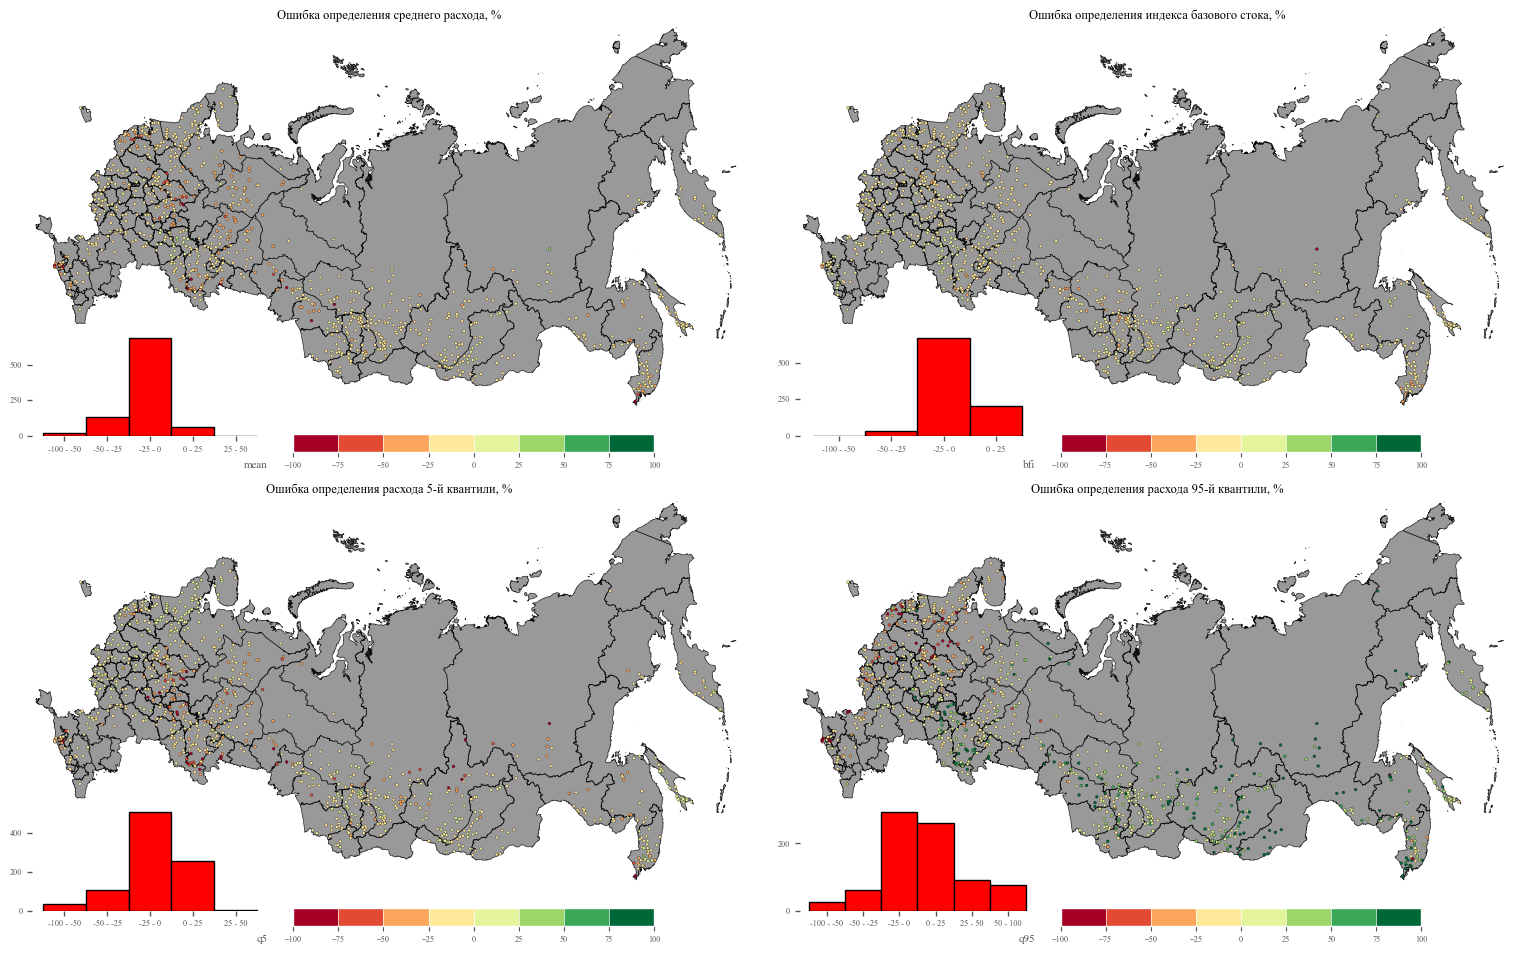

In [619]:
russia_plots_n(gdf_to_plot=tft_era5l,
               basemap_data=basemap_data,
               cmap_name='RdYlGn',
               figsize=(20, 10),
               list_of_limits=[-100, -50, -25, 0, 25, 50, 100],
               nrows=2,
               ncols=2,
               columns_from_gdf=['mean', 'bfi', 'q5', 'q95'],
               with_histogram=True, title_text=[f'Ошибка определения среднего расхода, %',
                                                f'Ошибка определения индекса базового стока, %',
                                                f'Ошибка определения расхода 5-й квантили, %',
                                                f'Ошибка определения расхода 95-й квантили, %']);
plt.savefig('../visualizations/into_dissertation/q5q95bfimean.png',
            dpi=650)

### Static parameters description

In [26]:
static_params = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_params = static_params.set_index('gauge_id')
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
static_final = static_params[static_parameters]

test_static = deepcopy(static_final)
for g_id in test_static.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static = test_static.drop(g_id)
        
test_static_big = deepcopy(static_params)
for g_id in test_static_big.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static_big = test_static_big.drop(g_id)

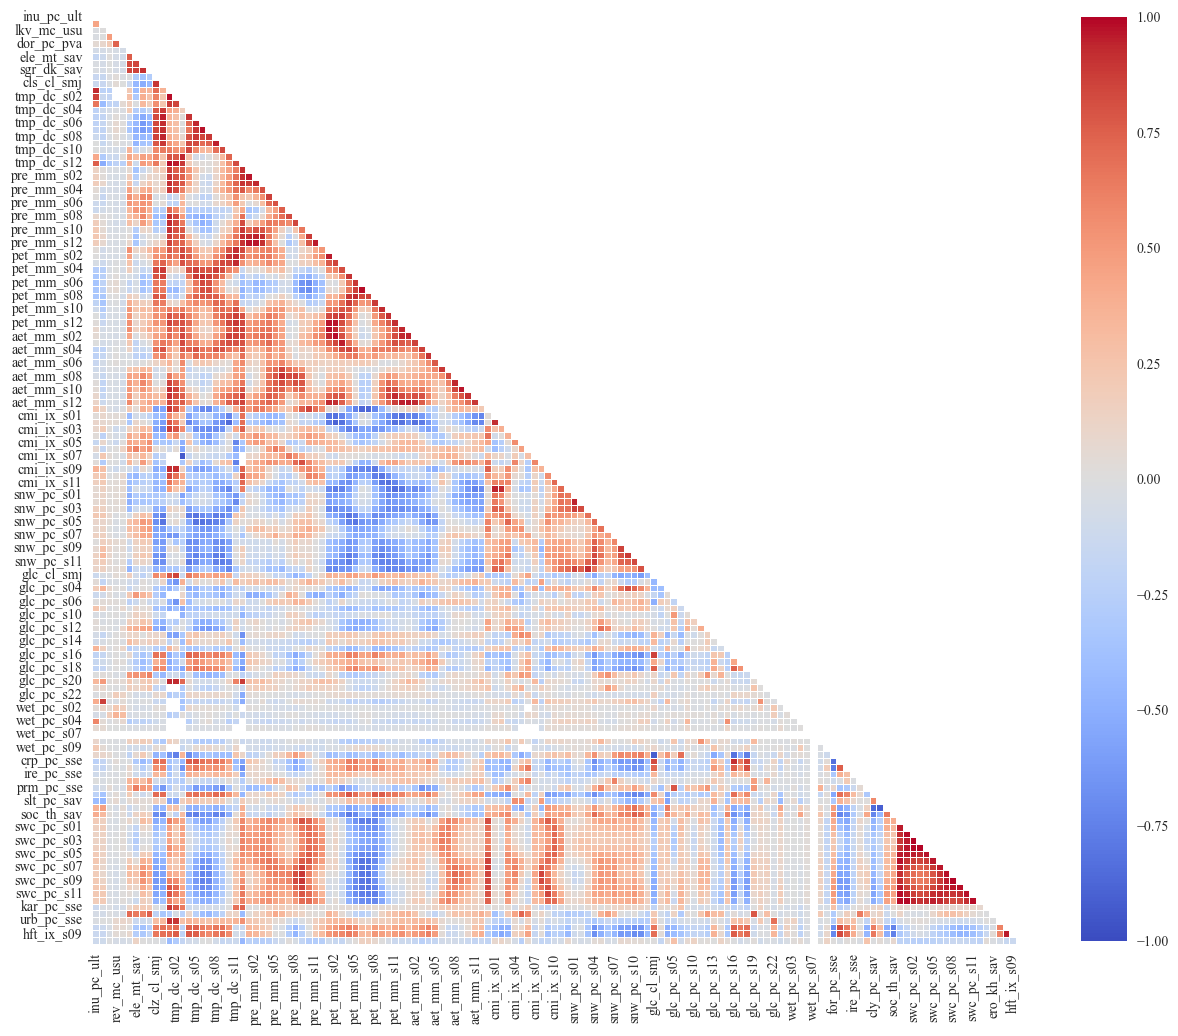

In [27]:
plt.rcParams["font.family"] = "Times New Roman"
# remove columns which had no representation in data
corr_frame = test_static_big.drop(['glc_pc_s01', 'glc_pc_s03',
                                 'glc_pc_s07', 'glc_pc_s08',
                                 'wet_pc_s05'], axis=1)
correlation_matrix = corr_frame.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8});
plt.savefig('../visualizations/into_dissertation/corr_mat_everything.png',
            dpi=650)


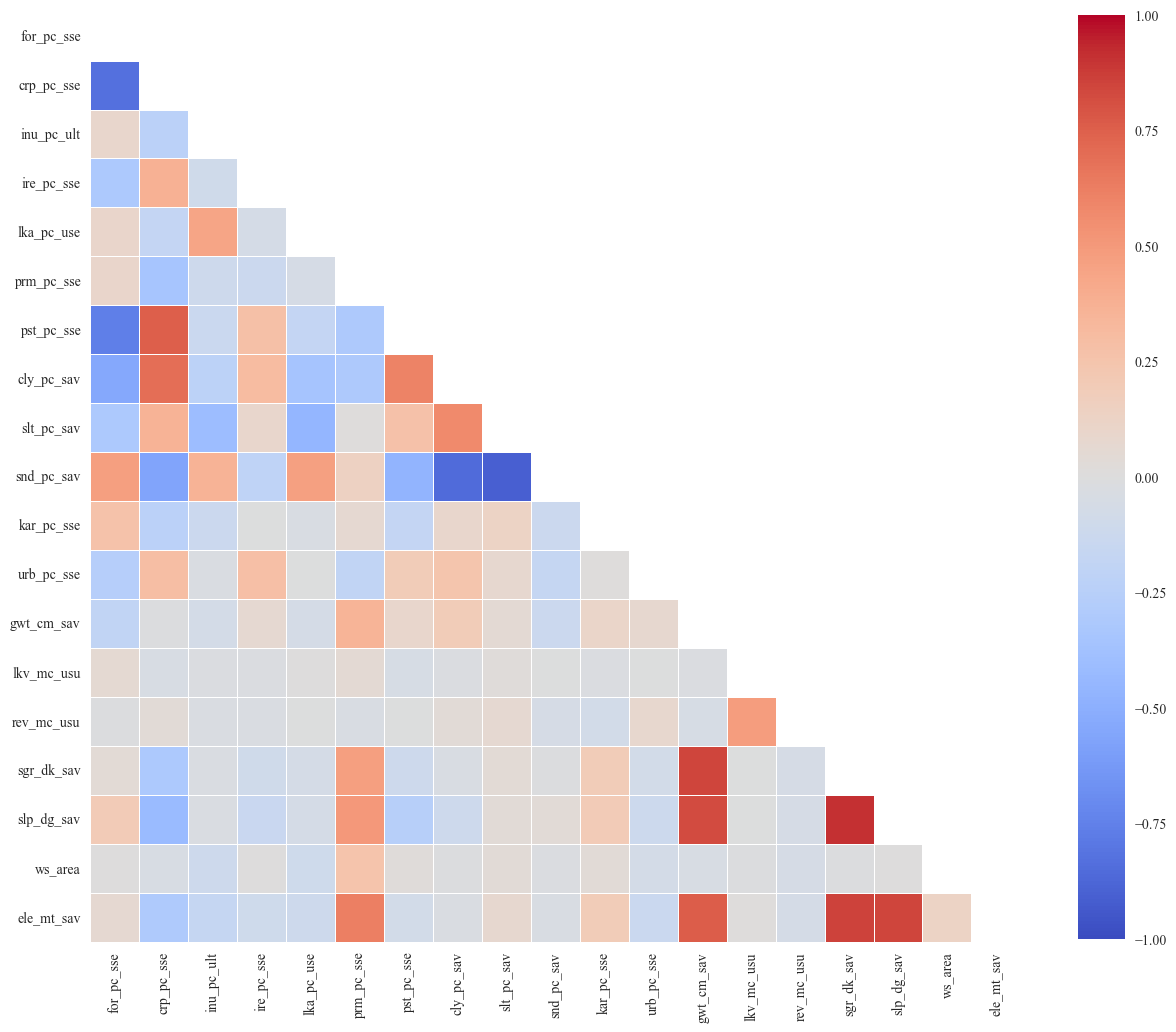

In [28]:
# remove columns which had no representation in data
correlation_matrix = test_static.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8});
plt.savefig('../visualizations/into_dissertation/corr_mat_final.png',
            dpi=650)


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

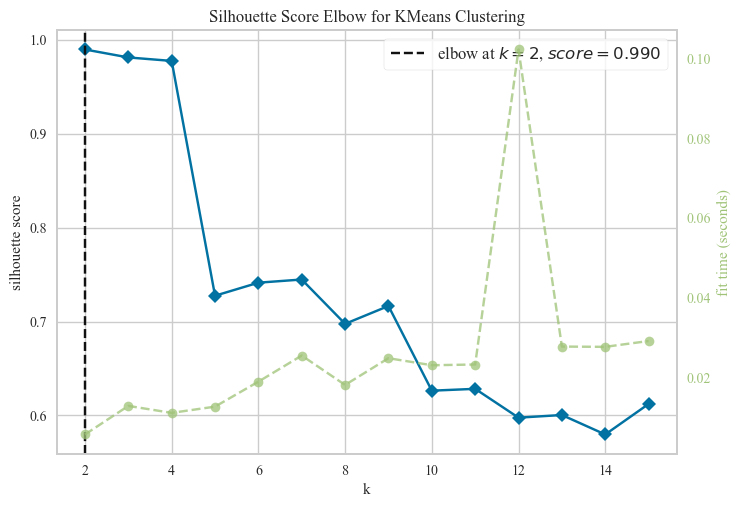

In [29]:
km = KMeans(n_init=6)
Elbow_M = KElbowVisualizer(estimator = km, k = 15, metric='silhouette')
Elbow_M.fit(test_static)
Elbow_M.show()

plt.show()

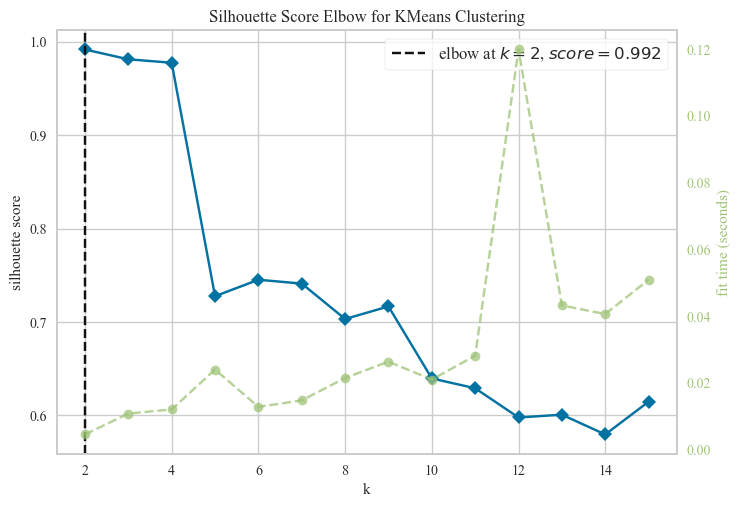

In [36]:
km = KMeans(n_init=6)
Elbow_M = KElbowVisualizer(estimator = km, k = 15, metric='silhouette')
Elbow_M.fit(test_static.to_numpy())
Elbow_M.show()

plt.show()

def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42, n_init=6)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["Количество кластеров", "Величина силуэта"])
    pivot_km = pd.pivot_table(result, index="Количество кластеров", values="Величина силуэта")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.show()

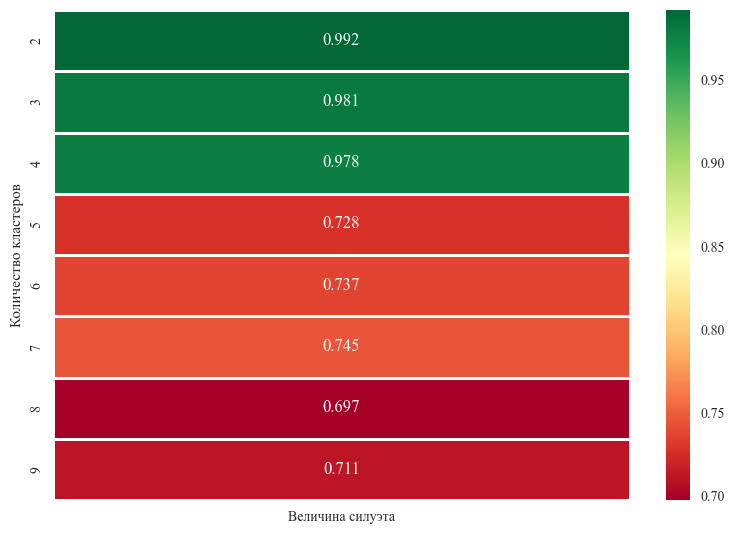

<Figure size 800x550 with 0 Axes>

In [38]:
visualize_silhouette_layer(test_static.to_numpy())
plt.savefig('../visualizations/into_dissertation/clusters_number.png',
            dpi=650)

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(test_static))

tft_era5l['Кластер'] = [i+1 for i in yhat_AC]

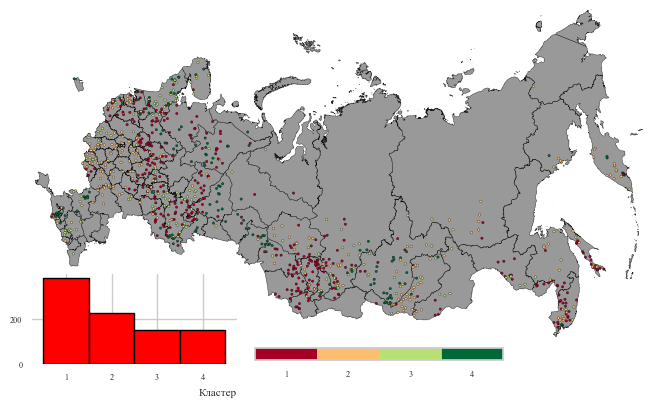

In [34]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='',
                          metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4],
                          figsize=(8, 6),
                          just_points=False,
                          with_histogram=True)
gauges_fig.savefig('../visualizations/into_dissertation/clusters_Rus.png',
                   dpi=650)